In [1]:
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback,AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat.textstat import textstatistics
import pandas as pd
import language_tool_python
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()

    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [3]:
MODEL="roberta-base"
N_SAMPLES=1000

df_test_original=pd.read_csv('datasets/features_df_test_extended.csv')

# For reduced dataset only
reduced_columns=['word_count','avg_sentence_length','avg_word_length','gunning_fog_index','grammatical_errors','text','label']
df_test_original=df_test_original[reduced_columns]

N_LABELS=df_test_original['label'].nunique()
print(f'N of labels: {N_LABELS}')

df_test_extraData=df_test_original.drop(['label'],axis=1)
df_test_extraData=df_test_extraData.drop(['text'],axis=1)

num_extra_dims = df_test_extraData.shape[1]
print(f'N of extra dimensions: {num_extra_dims}')

multidomain_model = CustomSequenceClassification.from_pretrained(MODEL, num_labels=N_LABELS,num_extra_dims=num_extra_dims)

N of labels: 6
N of extra dimensions: 5


Some weights of CustomSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'roberta.pooler.dense.bias', 'classifier.out_proj.bias', 'roberta.pooler.dense.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from tqdm import tqdm
tqdm.pandas()
from transformers import AutoTokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# Initialize the grammar checker
tool = language_tool_python.LanguageTool('en-US')

def extract_text_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)

    # Average sentence length
    avg_sentence_length = word_count / sentence_count

    # Average word length
    avg_word_length = sum(len(word) for word in words) / word_count

    # Readability scores
    fog_index = textstatistics().gunning_fog(text)

    # Grammatical errors
    matches = tool.check(text)
    grammatical_errors = len(matches)

    # Create a DataFrame
    return pd.Series({
        'word_count': word_count,
        'avg_sentence_length': avg_sentence_length,
        'avg_word_length': avg_word_length,
        'gunning_fog_index': fog_index,
        'grammatical_errors': grammatical_errors
    })

def preprocess_data():
    
    df_original=pd.read_csv('datasets/features_df_extended.csv').sample(N_SAMPLES)
    df_test_original=pd.read_csv('datasets/features_df_test_extended.csv')
    
    # For reduced dataset only
    df_original=df_original[reduced_columns]
    df_test_original=df_test_original[reduced_columns]

    df_original, df_val_original = train_test_split(df_original, test_size=0.2, stratify=df_original['label'], random_state=0)

    df_extraData=df_original.drop(['label'],axis=1)
    df_extraData=df_extraData.drop(['text'],axis=1)

    df_val_extraData=df_val_original.drop(['label'],axis=1)
    df_val_extraData=df_val_extraData.drop(['text'],axis=1)

    df_test_extraData=df_test_original.drop(['label'],axis=1)
    df_test_extraData=df_test_extraData.drop(['text'],axis=1)   

    ds_train = Dataset.from_dict({
        "text": df_original['text'].tolist(), 
        "extra_data": df_extraData.values.tolist(),
        "labels": df_original['label'].tolist()
    })

    ds_val = Dataset.from_dict({
        "text": df_val_original['text'].tolist(), 
        "extra_data": df_val_extraData.values.tolist(),
        "labels": df_val_original['label'].tolist()
    })

    ds_test = Dataset.from_dict({
        "text": df_test_original['text'].tolist(), 
        "extra_data": df_test_extraData.values.tolist(),
        "labels": df_test_original['label'].tolist()
    })
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    tokenized_ds_train = ds_train.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
    tokenized_ds_train = tokenized_ds_train.map(lambda x: {'extra_data': x['extra_data']})

    tokenized_ds_val = ds_val.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
    tokenized_ds_val = tokenized_ds_val.map(lambda x: {'extra_data': x['extra_data']})

    tokenized_ds_test = ds_test.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
    tokenized_ds_test = tokenized_ds_test.map(lambda x: {'extra_data': x['extra_data']})

    print(tokenized_ds_train,tokenized_ds_val,tokenized_ds_test)
    
    return(tokenized_ds_train,tokenized_ds_val,tokenized_ds_test)

def getMetrics(predicted_labels, true_labels):
    # Ensure the labels are numpy arrays
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro', zero_division=0)

    # Create a dictionary of metrics
    metrics = {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
    }

    return metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Load metrics
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    accuracy_metric = evaluate.load("accuracy")

    # Compute metrics with macro averaging and handle zero division
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compile results
    results = {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
    }

    return results

def fine_tune(train_df,val_df,test_df,checkpoints_path):
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=multidomain_model,
        args=training_args,
        train_dataset=train_df,
        eval_dataset=val_df,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    best_model_path = checkpoints_path+'/best/'
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)
    trainer.save_model(best_model_path)
    evaluation=trainer.evaluate(test_df)
    print(evaluation)
    return evaluation['eval_accuracy']
    
def test(test_df, model_path):
    # load tokenizer from saved model 
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # load best model
    model = AutoModelForSequenceClassification.from_pretrained(
       model_path, num_labels=N_LABELS,ignore_mismatched_sizes=True)
            
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(test_df)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    metric = evaluate.load("bstrai/classification_report")
    results = metric.compute(predictions=preds, references=predictions.label_ids)
    
    # return dictionary of classification report
    return results, preds


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ghiki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ghiki\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


500 - 0.37466666666666665
1000 - 0.5543333333333333
2000 - 0.6506666666666666
5000 - 0.6843333333333333
10000 - 0.6643333333333333
15000 - 0.7016666666666667
20000 - 0.6773333333333333
30000 - 0.7576666666666667
40000 - 0.7386666666666667
50000 - 0.7296666666666667
60000 - 0.7263333333333334
70000 - 0.759


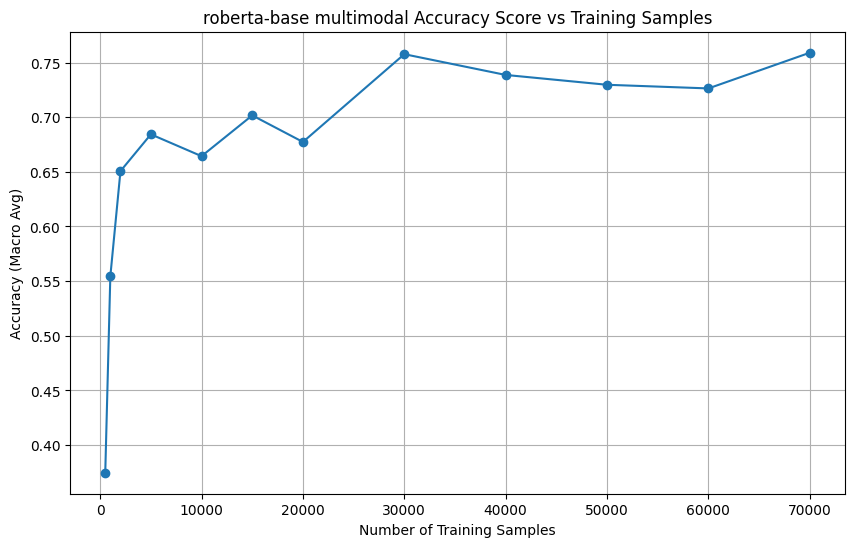

In [5]:
import json

samples=[500,1000,2000,5000,10000,15000,20000,30000,40000,50000,60000,70000]
f1_scores = []

for SAMPLES_TO_TRAIN in samples:
    N_SAMPLES=SAMPLES_TO_TRAIN
    tokenized_ds_train,tokenized_ds_val,tokenized_ds_test=preprocess_data()
    f1_score=fine_tune(tokenized_ds_train,tokenized_ds_val,tokenized_ds_test,f"testing_models/{MODEL.split('/')[-1]}_{N_SAMPLES}")
    
    with open(f"testing_models/{MODEL.split('/')[-1]}_{SAMPLES_TO_TRAIN}/best/acc_score.json", 'w') as file:
        json.dump({'acc_score': f1_score}, file)
    
    f1_scores.append(f1_score)
    
    print(f'\n\n****** {SAMPLES_TO_TRAIN} - {f1_score} ******\n\n')

from IPython.display import clear_output
clear_output(wait=True)

for SAMPLES_TO_TRAIN,f1_score in zip(samples,f1_scores):
    print(f'{SAMPLES_TO_TRAIN} - {f1_score}')

import matplotlib.pyplot as plt
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(samples, f1_scores, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (Macro Avg)')
plt.title(f'{MODEL} multimodal Accuracy Score vs Training Samples')
plt.grid(True)
plt.savefig(f"testing_models/{MODEL.split('/')[-1]}_optimized_acc_scores.png")
plt.show()

500 - 0.318
1000 - 0.6063333333333333
2000 - 0.5823333333333334
5000 - 0.6953333333333334
10000 - 0.6926666666666667
15000 - 0.7086666666666667
20000 - 0.712
30000 - 0.7176666666666667
40000 - 0.7136666666666667
50000 - 0.7343333333333333
60000 - 0.7386666666666667
70000 - 0.742


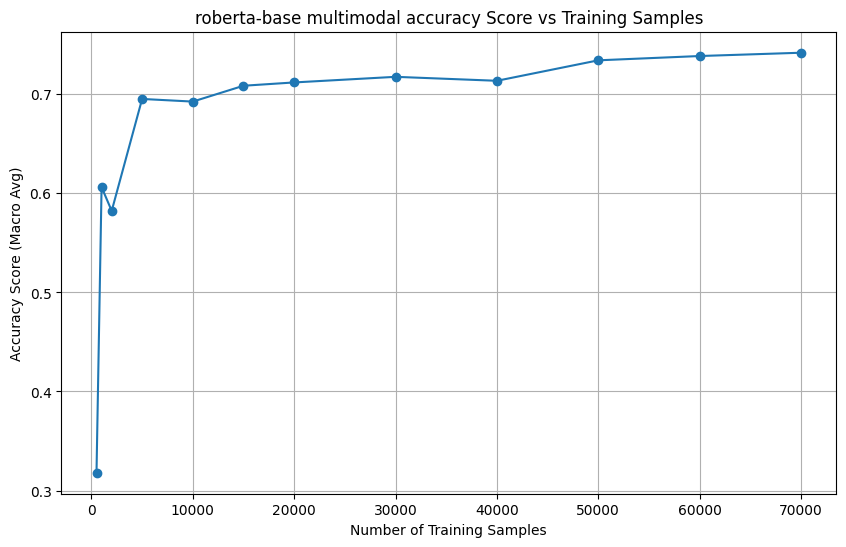

In [7]:
samples=[]
f1_scores=[]

a='''
500 - 0.318
1000 - 0.6063333333333333
2000 - 0.5823333333333334
5000 - 0.6953333333333334
10000 - 0.6926666666666667
15000 - 0.7086666666666667
20000 - 0.712
30000 - 0.7176666666666667
40000 - 0.7136666666666667
50000 - 0.7343333333333333
60000 - 0.7386666666666667
70000 - 0.742
'''
lines = a.split('\n')

a_values = []
b_values = []
for line in lines:
    try:
        value_a, value_b = line.split(' - ')
        a_values.append(int(value_a))  
        b_values.append(float(value_b))
    except:
        pass

samples=a_values
f1_scores=b_values

for SAMPLES_TO_TRAIN,f1_score in zip(samples,f1_scores):
    print(f'{SAMPLES_TO_TRAIN} - {f1_score}')

import matplotlib.pyplot as plt
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(samples, f1_scores, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy Score (Macro Avg)')
plt.title(f'{MODEL} multimodal accuracy Score vs Training Samples')
plt.grid(True)
plt.savefig(f"testing_models/{MODEL.split('/')[-1]}_optimized_acc_scores.png")
plt.show()

In [40]:
from transformers import RobertaConfig, RobertaModel
import torch

final_model_path=f"testing_models/{MODEL.split('/')[-1]}_{N_SAMPLES}/best/"

config = RobertaConfig.from_pretrained(final_model_path)
model = CustomSequenceClassification(config, num_extra_dims)
model.load_state_dict(torch.load(final_model_path+'/pytorch_model.bin'))

<All keys matched successfully>

In [43]:
trainer = Trainer(model=model,compute_metrics=compute_metrics)
evaluation=trainer.evaluate(tokenized_ds_test)

100%|██████████| 625/625 [00:24<00:00, 25.83it/s]


In [45]:
evaluation['eval_f1']

0.7571265678449258